# E22. 폐렴아 기다려라!

## 의료 영상의 종류
* X-RAY: 전자를 물체에 충돌시킬 때 발생하는 투과력이 강한 복사선(전자기파)
* CT (Computed Tomography): 환자를 중심으로 X-RAY를 빠르게 회전하여 3D 이미지를 만들어내는 영상
* MRI (Magnetic Resonance Imaging, 자기 공명 영상): 신체의 해부학적 과정과 생리적 과정을 보기 위해 사용하는 의료 영상 기술. 강한 자기장를 사용하여 신체 기관의 이미지를 생성한다.
* https://www.youtube.com/watch?v=J_Owz3YBkD0

## X-RAY 이미지
* 의료 영상 촬영은 인체를 세 방향의 단면으로 나눈다
    - 시상면 (sagittal plane): 사람을 왼쪽과 오른쪽을 나누는 면
    - 관상면 (coronal plane): 인체를 앞 뒤로 나누는 면
    - 횡단면 (수평면) (transverse plane): 인체를 상하로 나누는 면
* X-RAY: 전자기파가 몸을 통과한 결과를 이미지화시킨 것. 색상이 아니라 흑백 명암으로 나오게 되며, 부위에 따라 명함이 다르다

## 폐렴을 진단해보자
* Chest X-Ray Images (Pneumonia): 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X 선 영상 https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
```
$ mkdir -p ~/aiffel/chest_xray
$ cd ~/Downloads && unzip archive.zip -d ~/aiffel
```
* 폐렴 구별법: 폐 부위에 다양한 양상의 음영이 있을 경우
    - 세균성 폐렴: 오른쪽 상부
    - 바이러스성 폐렴: 양쪽 폐의 interstitial (조직 사이에 있는)

### setup: 필요한 모듈 import

In [5]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

In [6]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = ''
print(ROOT_PATH)

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 25

In [7]:
if ROOT_PATH != '' and not ROOT_PATH.endswith('/'):
    ROOT_PATH = ROOT_PATH + '/'

train_filenames = tf.io.gfile.glob(str(ROOT_PATH + 'chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + 'chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + 'chest_xray/val/*/*'))

# 각 데이터의 수 체크
print(len(train_filenames)) # 5216 (89%)
print(len(test_filenames)) # 624 (10.7%)
print(len(val_filenames)) # 16 (0.3%)

5216
624
16


### 데이터 가져오기
* val에 쓰일 데이터 수가 너무 적기 때문에, train에서 일부 가져오기
* train 8, val 2 정도로 분할

In [8]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + 'chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + 'chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames)) # 4185
print(len(val_filenames)) # 1047

4185
1047


In [9]:
# train 내 정상 이미지 수, 폐렴 이미지 수 확인
# 정상 1085, 폐렴 3100으로 현재는 불균형한 상태
# test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제 없음

COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1064
Pneumonia images count in training set: 3121


In [10]:
# tf.data 인스턴스 생성
# tf.data: 배치 처리 작업을 보다 효율적으로 할 수 있도록 해줌

train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# train 데이터 셋, validation 데이터 셋 갯수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT)) # 4185

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT)) # 1047

Training images count: 4185
Validating images count: 1047


In [12]:
# 라벨 이름 확인

CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "chest_xray/train/*"))])
print(CLASS_NAMES) # ['PNEUMONIA' 'NORMAL']

['PNEUMONIA' 'NORMAL']


In [13]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

* 이미지 사이즈를 통일하고 줄이기
* 이미지 데이터 타입을 float으로 바꾸기
* 라벨 값 가져오기

In [14]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

* train, validation 데이터셋 만들기

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
# 리사이징, 라벨링 잘 되었는지 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


* test 데이터셋 만들기

In [17]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + 'chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


* ```prepare_for_training()```: 학습을 효율적으로 할 수 있도록 데이터 변환
* ```shuffle()```: 고정 크기 버퍼를 유지하고, 해당 버퍼에서 무작위로 균일하게 다음 요소 선택
* ```repeat()```: epoch 진행하면서 데이터셋을 여러번 사용할 수 있게 해줌
* ```batch()```: ```BATCH_SIZE``` 만큼 배치로 주어짐
* ```prefetch()```: 학습 데이터를 나눠서 읽어오고, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 준비할 수 있어 리소스의 유휴 상태를 줄여줌

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

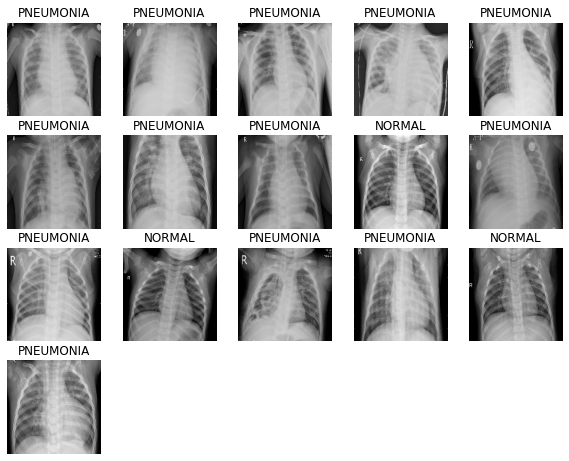

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링
* http://taewan.kim/post/cnn/
* ```conv_block()``` 의 구성
    - Convolution을 두번 진행하고
    - Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결
    - 그리고 Max Pooling

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

> 어떤 부분이 가장 특이한가요? 눈에 띄셨을지 모르겠지만, 방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두가지 regularization 기법이 동시에 사용되고 있습니다. 일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 합니다.
그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아닙니다. 예외적으로 동시에 사용하는 것이 성능향상에 도움을 주는 경우가 실제로 있습니다. 
* https://openaccess.thecvf.com/content_CVPR_2019/papers/Li_Understanding_the_Disharmony_Between_Dropout_and_Batch_Normalization_by_Variance_CVPR_2019_paper.pdf   
* https://arxiv.org/pdf/1905.05928.pdf

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리
* weight balancing 테크닉 사용: training set 의 각 데이터에서 loss 를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법
    - keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원
    - https://3months.tistory.com/414
* ```weight_for_0```: 'Normal' 이미지에 사용할 weight 세팅
* ```weight_for_1```: 'Pneumonia' 이미지에 사용할 weight를 세팅
* 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


### 모델 훈련
* 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용
* optimizer로 'adam'을 사용
* 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 24s 90ms/step - loss: 0.3784 - accuracy: 0.8056 - precision: 0.9564 - recall: 0.7746 - val_loss: 0.6553 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 23s 89ms/step - loss: 0.2382 - accuracy: 0.9097 - precision: 0.9730 - recall: 0.9040 - val_loss: 1.8967 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 23s 88ms/step - loss: 0.2072 - accuracy: 0.9236 - precision: 0.9807 - recall: 0.9155 - val_loss: 0.9410 - val_accuracy: 0.7279 - val_precision: 0.7276 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 23s 88ms/step - loss: 0.1805 - accuracy: 0.9351 - precision: 0.9827 - recall: 0.9294 - val_loss: 0.6860 - val_accuracy: 0.7788 - val_precision: 1.0000 - val_recall: 0.6974
Epoch 5/25
261/261 [==============================] - 23s 89ms/step - loss: 0.1662 - accuracy: 0

### 결과 확인

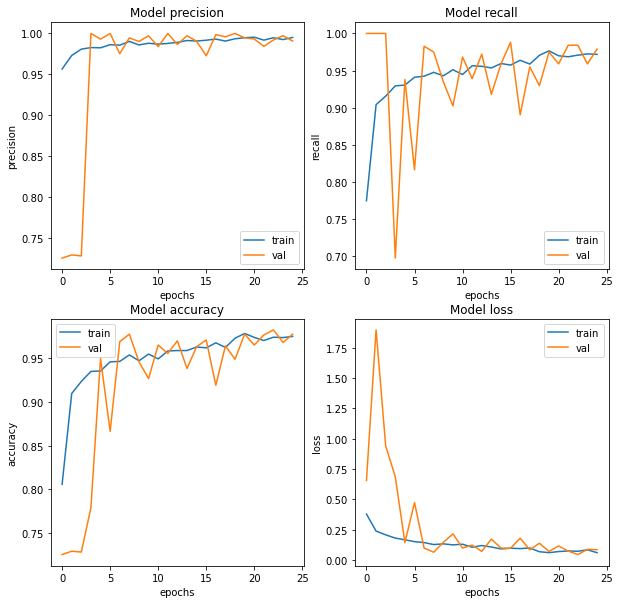

In [22]:
# 매 epoch마다 precision, recall, accuracy, loss가 어떻게 변했는지 확인

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 테스트 데이터로 모델 평가

loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.2289 - accuracy: 0.7853 - precision: 0.7500 - recall: 0.9846


## 프로젝트: 폐렴 진단기 성능 개선

### 실험 환경 setup
* batch size, epoch 등 변경해보기

In [18]:
BATCH_SIZE = 16
EPOCHS = 20 # 15 -> 20

### 데이터 준비하기
* 아래는 좌우반전 augmentation 도입 시 코드
* 다만, augmentation 도입은 신중해야 한다
> 의료영상인 경우, 일반적인 이미지처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

In [19]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화
* 만약 augmentation을 시도했다면 이후 실습코드에 있는 show_batch() 함수를 통해 실제로 좌우반전 등이 제대로 처리되었는지 확인

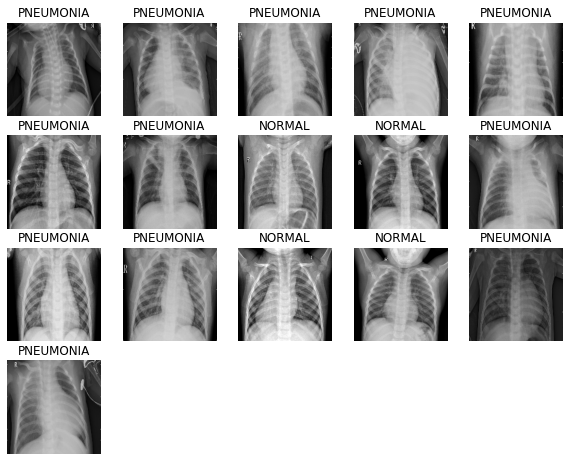

In [20]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링
* Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있다
* Batch Normalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있다. 또, Dropout 비율을 변경해볼 수도 있다
* (참고) dropout https://pythonkim.tistory.com/42

In [21]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        # tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2), # 0.2 -> 0.5 -> 0.2
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2), # 0.2 -> 0.5 -> 0.2
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 데이터 imbalance 처리
* ```class_weight``` 설정을 생략하면?
* recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 순 없을까?

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


### 모델 훈련
* loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려할 수 있다

In [23]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 23s 89ms/step - loss: 0.2564 - accuracy: 0.8925 - precision: 0.9778 - recall: 0.8757 - val_loss: 0.7921 - val_accuracy: 0.7288 - val_precision: 0.7288 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 23s 88ms/step - loss: 0.1639 - accuracy: 0.9370 - precision: 0.9795 - recall: 0.9352 - val_loss: 1.1814 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 22s 85ms/step - loss: 0.1679 - accuracy: 0.9368 - precision: 0.9801 - recall: 0.9341 - val_loss: 0.2772 - val_accuracy: 0.8654 - val_precision: 0.8445 - val_recall: 0.9987
Epoch 4/20
261/261 [==============================] - 22s 86ms/step - loss: 0.1260 - accuracy: 0.9545 - precision: 0.9883 - recall: 0.9502 - val_loss: 0.1206 - val_accuracy: 0.9577 - val_precision: 0.9624 - val_recall: 0.9802
Epoch 5/20
261/261 [==============================] - 22s 85ms/step - loss: 0.1333 - accuracy: 0

### 결과 확인과 시각화
* 우선은 accuracy를 고려해야겠지만 의료영상 모델의 특성상 recall도 중요

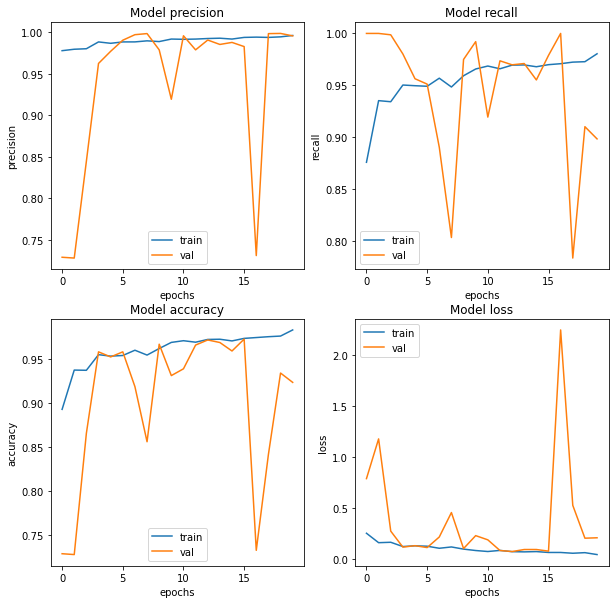

In [25]:
# 매 epoch마다 precision, recall, accuracy, loss가 어떻게 변했는지 확인

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
# 테스트 데이터로 모델 평가

loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 54ms/step - loss: 0.5811 - accuracy: 0.8526 - precision: 0.8282 - recall: 0.9641


### 정리
* 실습시 조건 중 다음을 변경했다.
    - ```epoch```: 25 -> 20
    - ```dense_block()``` 의 dropout 삭제
* 그 결과 accuracy가 실습시 (0.7853) 보다 높은 **0.8526** 으로 측정되었다.